<a href="https://colab.research.google.com/github/FarahBouattour/knowWhatToEat/blob/main/DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
print(tf.__version__)

2.5.0


In [11]:
# Window dataset, we're going to use it on x_train
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1) # This is required since we have specified a specific input function in the model
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

###univariate time series LSTM first try

In [12]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

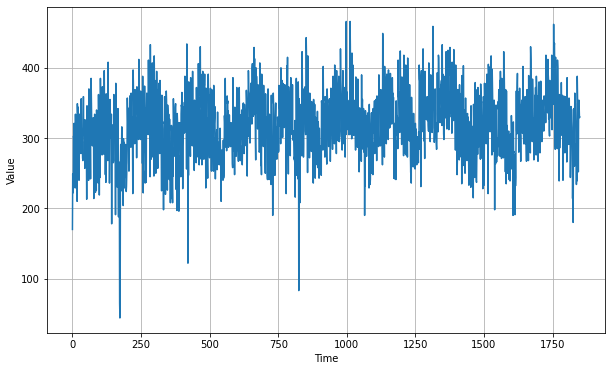

In [14]:
#df = pd.read_csv('reffined_data.csv')
df = pd.read_csv('data_pca_dt_covid_fi.csv')
df = df.iloc[:1850]

series = np.array(df['flux_journalier'])
#time_step = np.array(df['Date'])
time = np.array([i for i in range(len(df))]) 
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [15]:
series.shape
time.shape

(1850,)

In [16]:
series.dtype

dtype('int64')

In [17]:
series

array([170, 249, 222, ..., 346, 329, 330])

In [56]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(series.reshape(-1,1))
series = scaler.transform(series.reshape(-1,1))


split_time = 1250  #600
time_train = time[:split_time]
x_train = series[:split_time] 
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30 # 30 slices worth of data, so we're splitting the x_train 30 times !!!
batch_size = 30

print('total',series.shape)
print('train',x_train.shape)
print('test', x_valid.shape)

total (1850, 1)
train (1250, 1)
test (600, 1)


In [57]:
# We take the DNN model, and we try to apply it to our series use the window technique
# So after training it will help us forecast
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    # No map or shuffle, this was done in the windowed_dataset()
    forecast = model.predict(ds)
    return forecast

In [58]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

batch_size = 128
shuffle_buffer = 100
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer) # We take a window of x_train
print("train_set= ",train_set)
print("\n x_train.shape= ",x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=16, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]), # We have specified the input shape here so we need to change the windowed_dataset()
  tf.keras.layers.LSTM(16, return_sequences=True),
  tf.keras.layers.SimpleRNN(256, return_sequences=True),
  tf.keras.layers.Dense(60, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])

# The whole purpose of this cell is to know which learning rate to use using the lr_schedule
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=20, callbacks=[lr_schedule])


train_set=  <PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>

 x_train.shape=  (1250, 1)
Epoch 1/20
10/10 [==============================] - 3s 44ms/step - loss: 3.9543 - mae: 4.4142
Epoch 2/20
10/10 [==============================] - 0s 45ms/step - loss: 1.5818 - mae: 2.0209
Epoch 3/20
10/10 [==============================] - 0s 44ms/step - loss: 1.0566 - mae: 1.4705
Epoch 4/20
10/10 [==============================] - 0s 44ms/step - loss: 0.6239 - mae: 1.0100
Epoch 5/20
10/10 [==============================] - 0s 47ms/step - loss: 0.3921 - mae: 0.7434
Epoch 6/20
10/10 [==============================] - 0s 46ms/step - loss: 0.2660 - mae: 0.5894
Epoch 7/20
10/10 [==============================] - 0s 42ms/step - loss: 0.1816 - mae: 0.4756
Epoch 8/20
10/10 [==============================] - 0s 42ms/step - loss: 0.1296 - mae: 0.3949
Epoch 9/20
10/10 [==============================] - 0s 40ms/step - loss: 0.0937 - mae: 0.3339
Epoch 10/20
10

In [59]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
print("1",rnn_forecast)
print(rnn_forecast.shape)
rnn_forecast = rnn_forecast[split_time - window_size:-1,-1,0] 
print("\n2",np.array(rnn_forecast.shape))

1 [[[0.71887475]
  [0.67630714]
  [0.6175857 ]
  ...
  [0.90526414]
  [0.75357705]
  [0.82354957]]

 [[0.6961529 ]
  [0.6434869 ]
  [0.592546  ]
  ...
  [0.8491682 ]
  [0.8847959 ]
  [0.784084  ]]

 [[0.7024832 ]
  [0.6507067 ]
  [0.6457069 ]
  ...
  [0.87866783]
  [0.86345226]
  [0.84682584]]

 ...

 [[0.6885098 ]
  [0.71513706]
  [0.68662345]
  ...
  [0.8452122 ]
  [0.75225616]
  [0.74832463]]

 [[0.69533336]
  [0.7380389 ]
  [0.659382  ]
  ...
  [0.8077597 ]
  [0.75880575]
  [0.7617121 ]]

 [[0.6917054 ]
  [0.70987993]
  [0.6369654 ]
  ...
  [0.908749  ]
  [0.76550186]
  [0.8017444 ]]]
(1821, 30, 1)

2 [600]


(600,)
(600, 1)
(600,)


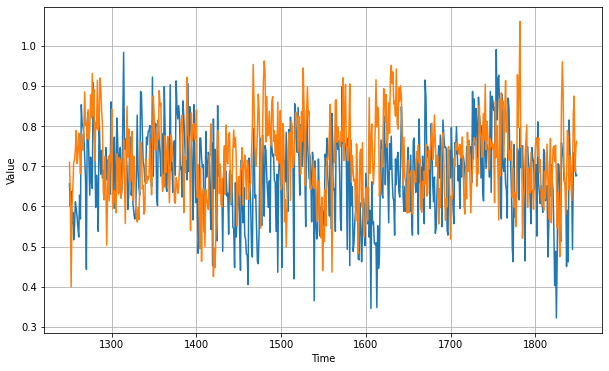

In [60]:
print(time_valid.shape)      
print(x_valid.shape)         
print(rnn_forecast.shape)    
plt.figure(figsize=(10, 6))
title = str("Forecasting with LSTM")
plot_series(time_valid, x_valid) # 2-D
plot_series(time_valid, rnn_forecast) # we only took the last part of the rnn_forecast

In [43]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy() # CNN LSTM 1.77

array([0.09031472, 0.13654959, 0.1047554 , 0.17770763, 0.14968576,
       0.21799195, 0.18481661, 0.12617187, 0.14085804, 0.1588564 ,
       0.18718626, 0.21088299, 0.11233457, 0.16588594, 0.12400547,
       0.08695523, 0.0821773 , 0.07076581, 0.05824556, 0.08357415,
       0.29145166, 0.09197581, 0.10824274, 0.05974749, 0.11233457,
       0.05851521, 0.08689758, 0.09923911, 0.17447795, 0.10824274,
       0.0579145 , 0.13869229, 0.0758405 , 0.10851124, 0.19666494,
       0.10635252, 0.05933286, 0.07441029, 0.05806955, 0.08040623,
       0.06920123, 0.07303346, 0.07169926, 0.0589319 , 0.08357415,
       0.05974749, 0.06499093, 0.09561537, 0.11041578, 0.13019802,
       0.06831074, 0.11233457, 0.08197777, 0.06718636, 0.14085804,
       0.08040623, 0.09718984, 0.06319916, 0.10851124, 0.05790018,
       0.0589319 , 0.11427645, 0.10106641, 0.09369674, 0.2488327 ,
       0.05828592, 0.06508635, 0.05828592, 0.06806055, 0.14304072,
       0.11041578, 0.05828592, 0.06718636, 0.11233457, 0.08859